In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, optimizers, callbacks, metrics
from tensorflow.keras import backend as K, initializers, regularizers, constraints
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.layers import Concatenate, Bidirectional, ELU, LSTM, Activation, Dense, Dropout, Input, Embedding, Concatenate, Dense, Conv1D, AveragePooling1D, MaxPooling1D, Flatten, Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🎯 **Step 1: Load Dataset**
---

In [ ]:
path = '/content/drive/MyDrive/TUGAS AKHIR/Notebook/TESTING/PESAN TEKS/DATASET_TES.xlsx'

df_msg = pd.read_excel(path)

df_msg.head()

,Data,Kategori
0,"Salam, saya Wina dari HRD Tokopedia Indonesia....",phishing
1,"Halo, kami dari Tim Rekrutmen Shopee, ingin me...",phishing
2,Selamat! Anda terpilih untuk mendapatkan vouch...,phishing
3,"Hai, saya Fitri dari Customer Service Gojek. K...",phishing
4,"Halo, pinjaman sebesar Rp 10 juta Anda telah d...",phishing


In [ ]:
jumlah_per_kategori = df_msg['Kategori'].value_counts()
print(jumlah_per_kategori)

Kategori
phishing        25
non-phishing    25
Name: count, dtype: int64


In [ ]:
msgs = df_msg['Data'].tolist()

# 🎯 **Step 2: Preprocessing**
---

In [ ]:
with open('/content/drive/MyDrive/TUGAS AKHIR/Notebook/PESAN TEKS/Tokenizer/tokenizer_char_level.json', 'r', encoding='utf-8') as f:
    tokenizer_config = json.load(f)

tokenizer_char_level = tokenizer_from_json(tokenizer_config)

In [ ]:
with open('/content/drive/MyDrive/TUGAS AKHIR/Notebook/PESAN TEKS/Tokenizer/tokenizer_word_level.json', 'r', encoding='utf-8') as f:
    tokenizer_config = json.load(f)

tokenizer_word_level = tokenizer_from_json(tokenizer_config)

In [ ]:
def load_dataset_slang(path):

  with open(path, 'r') as file:

    slang_words = json.load(file)

  return slang_words

In [ ]:
path = [
    '/content/drive/MyDrive/TUGAS AKHIR/Notebook/Dataset/SLANG WORDS/json_slang_words1',
    '/content/drive/MyDrive/TUGAS AKHIR/Notebook/Dataset/SLANG WORDS/json_slang_words2',
    '/content/drive/MyDrive/TUGAS AKHIR/Notebook/Dataset/SLANG WORDS/json_slang_words3'
]

slang_words1 = load_dataset_slang(path[0])

slang_words2 = load_dataset_slang(path[1])

slang_words3 = load_dataset_slang(path[2])

In [ ]:
!pip -q install Sastrawi

import json
import re
import string
import nltk

from itertools import islice
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import tokenizer_from_json

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_global(text):

    text = text.lower()

    # print(text)

    text = re.sub(r'@', '', text)

    text = re.sub(r'#[A-Za-z0-9]+', '', text)

    text = re.sub(r'RT[\s]', '', text)

    text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", '', text)

    text = text.replace('/',' ')

    # text = re.sub(r'[0-9]+', '', text)

    # text = re.sub(r'pic\.twitter\.com/[^\s]+', '', text)

    text = re.sub(r'\.+', ' ', text)

    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) #remove emoji

    text = text.replace('\n', ' ')

    text = text.replace("'", "")

    text = text.replace(']','')

    text = text.replace('[','')

    text = text.replace(',',', ')

    text = text.replace('\\', ' ')

    text = text.replace('-',' ')

    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation from a text

    text = text.strip() # remove spaces (whitespace) at the beginning and at the end

    # print(text)

    words = text.split()

    for i, word in enumerate(words):

        if word in slang_words1.keys():

            words[i] = slang_words1[word]

        elif word in slang_words2.keys():

            words[i] = slang_words2[word]

        elif word in slang_words3.keys():

            words[i] = slang_words3[word]

    text = ' '.join(words)

    # print(text)

    text = word_tokenize(text)

    # print(text)

    factory = StemmerFactory()

    stemmer = factory.create_stemmer()

    stemmed_text = []

    for word in text:

        if word.lower() in ["asian", "basis", "solusi", "sufix"]:

            # Save the words without stemming
            stemmed_text.append(word)

        elif word.lower() == "ngutang" or word.lower() == "utang":

            stemmed_text.append("hutang")

        elif word.lower() == "menemani":

            stemmed_text.append("teman")

        else:

            stemmed_text.append(stemmer.stem(word))

    # print(stemmed_text)

    stop_factory = StopWordRemoverFactory()

    stopword = stop_factory.get_stop_words()

    filtered = []

    for txt in stemmed_text:

        if txt not in set(stopword) or txt.lower() == 'tidak':

            filtered.append(txt)

    text = filtered

    # print(text)

    text = ' '.join(text)

    # print(text)

    return text

def preprocess_char_level(text):
    X_cl_sequences = tokenizer_char_level.texts_to_sequences(text)
    X_cl_padded = pad_sequences(X_cl_sequences, padding='post', truncating='post', maxlen=1000)
    return X_cl_padded

def preprocess_word_level(text):
    X_wl_sequences =  tokenizer_word_level.texts_to_sequences(text)
    X_wl_padded = pad_sequences(X_wl_sequences, padding='post', truncating='post', maxlen=1000)
    return X_wl_padded

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
msg_clean = [preprocess_global(msg) for msg in msgs]

msg_char_level = preprocess_char_level(msg_clean)
print(msg_char_level)
msg_word_level = preprocess_word_level(msg_clean)
print(msg_word_level)

[[ 8  3 13 ...  0  0  0]
 [14  3 13 ...  0  0  0]
 [ 8  7 13 ...  0  0  0]
 ...
 [ 8  3 12 ...  0  0  0]
 [ 8 14 16 ...  0  0  0]
 [15  9 16 ...  0  0  0]]
[[ 267    1    1 ...    0    0    0]
 [  55   82 1349 ...    0    0    0]
 [  20   24  101 ...    0    0    0]
 ...
 [  42    1    1 ...    0    0    0]
 [ 299   34 2354 ...    0    0    0]
 [ 120  217    1 ...    0    0    0]]


In [ ]:
inputs = [msg_char_level, msg_word_level]

# 🎯 **Step 3: Load Model**
---

In [ ]:
import tensorflow as tf

def load_model(paths):
    models = []

    for path in paths:
        model = tf.keras.models.load_model(path)
        models.append(model)

    return models

In [ ]:
# paths_best_model = [
#     '/content/drive/MyDrive/TUGAS AKHIR/Notebook/PESAN TEKS/Model/Message_Embedding_v1_CNN_LSTM_Multi Head Attention_Model_After_Preprocess_Hyperparameter_Tuning(Best_Model).h5',
#     '/content/drive/MyDrive/TUGAS AKHIR/Notebook/PESAN TEKS/Model/Message_Embedding_v1_CNN_BiLSTM_Multi Head Attention_Model_After_Preprocess_Hyperparameter_Tuning(Best_Model).h5',
#     '/content/drive/MyDrive/TUGAS AKHIR/Notebook/PESAN TEKS/Model/Message_Embedding_v2_CNN_LSTM_Multi Head Attention_Model_Random_After_Preprocess_Hyperparameter_Tuning(Best_Model).h5',
#     '/content/drive/MyDrive/TUGAS AKHIR/Notebook/PESAN TEKS/Model/Message_Embedding_v2_CNN_BiLSTM_Multi Head Attention_Model_Random_After_Preprocess_Hyperparameter_Tuning(Best_Model).h5'
# ]

# best_model = load_model(paths_best_model)

In [ ]:
paths_best_model_train_again = [
    '/content/drive/MyDrive/TUGAS AKHIR/Notebook/PESAN TEKS/Model/Message_Embedding_v1_CNN_LSTM_Multi Head Attention_Model_After_Preprocess_Hyperparameter_Tuning_1.h5',
    '/content/drive/MyDrive/TUGAS AKHIR/Notebook/PESAN TEKS/Model/Message_Embedding_v1_CNN_BiLSTM_Multi Head Attention_Model_After_Preprocess_Hyperparameter_Tuning_1.h5',
    '/content/drive/MyDrive/TUGAS AKHIR/Notebook/PESAN TEKS/Model/Message_Embedding_v2_CNN_LSTM_Multi Head Attention_Model_Random_After_Preprocess_Hyperparameter_Tuning_1.h5',
    '/content/drive/MyDrive/TUGAS AKHIR/Notebook/PESAN TEKS/Model/Message_Embedding_v2_CNN_BiLSTM_Multi Head Attention_Model_Random_After_Preprocess_Hyperparameter_Tuning_1.h5'
]

best_model_train = load_model(paths_best_model_train_again)

# 🎯 **Step 4: Predict**
---

In [ ]:
def plot_pie_chart(model_predictions, model_name):
    phishing_actual = df_msg['Kategori'] == 'phishing'
    non_phishing_actual = ~phishing_actual

    phishing_predicted_phishing = (phishing_actual & (model_predictions == 1)).sum()
    phishing_predicted_non_phishing = (phishing_actual & (model_predictions == 0)).sum()
    non_phishing_predicted_phishing = (non_phishing_actual & (model_predictions == 1)).sum()
    non_phishing_predicted_non_phishing = (non_phishing_actual & (model_predictions == 0)).sum()

    labels = ['Smishing Diprediksi Smishing', 'Smishing Diprediksi Non-Smishing',
              'Non-Smishing Diprediksi Smishing', 'Non-Smishing Diprediksi Non-Smishing']
    sizes = [phishing_predicted_phishing, phishing_predicted_non_phishing,
             non_phishing_predicted_phishing, non_phishing_predicted_non_phishing]
    colors = ['#FF2567', '#FF7D97', '#9CECC5', '#39D98A']
    explode = (0, 0, 0, 0)  # hanya meledakkan bagian pertama

    plt.figure(figsize=(10, 6))
    wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', startangle=140)
    for autotext in autotexts:
        autotext.set_fontsize(16)
        autotext.set_fontweight('bold')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Hasil Prediksi {model_name}')
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model_predictions, model_name):
    actual = df_msg['Kategori'].apply(lambda x: 1 if x == 'phishing' else 0)
    cm = confusion_matrix(actual, model_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Smishing', 'Smishing'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix {model_name}')
    plt.show()

In [ ]:
def ensemble_predict(models, inputs, threshold=0.5):
    predictions_probs = [model.predict(inputs) for model in models]
    predictions = [(pred_prob > threshold).astype(int) for pred_prob in predictions_probs]

    return predictions

In [ ]:
# prediksi = ensemble_predict(best_model, inputs)

In [ ]:
# for i, pred in enumerate(prediksi):
#     df_msg[f'Model {i+1}'] = pred

In [ ]:
# for i in range(1, 5):
#     plot_pie_chart(df_msg[f'Model {i}'], f'Model {i}')

In [ ]:
prediksi_train = ensemble_predict(best_model_train, inputs)

2/2 [==============================] - 1s 96ms/step


In [ ]:
for i, pred in enumerate(prediksi_train):
    df_msg[f'Arsitektur {i+1}'] = pred

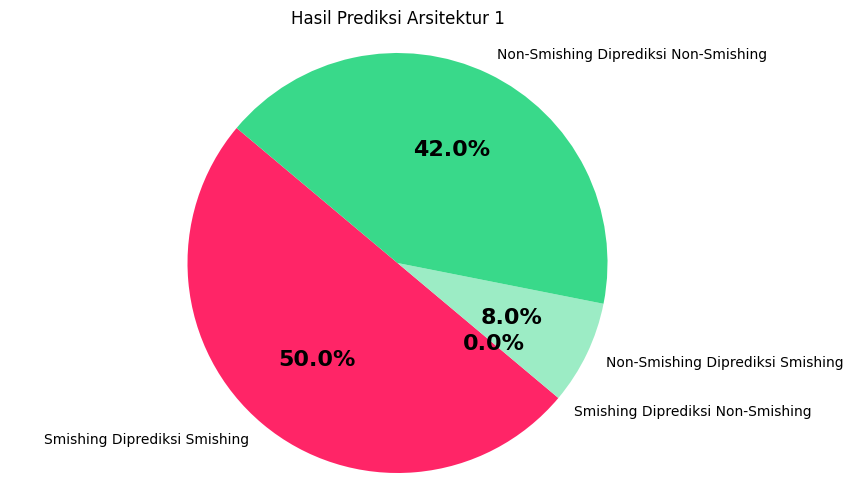

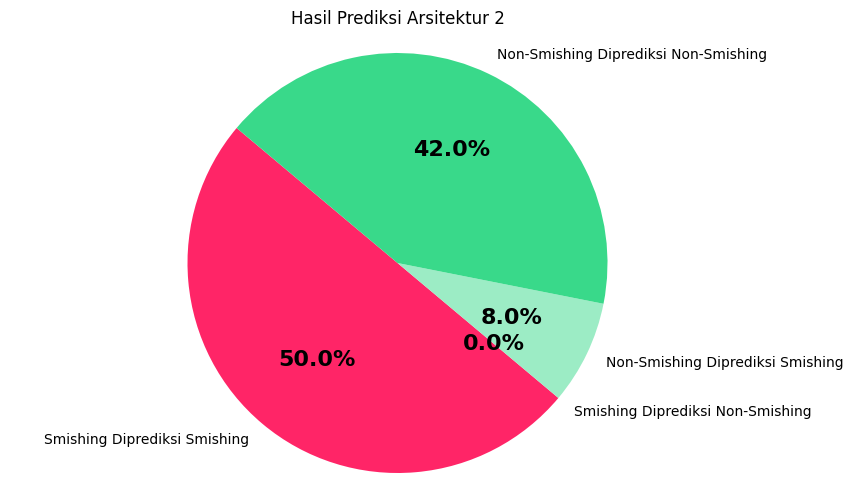

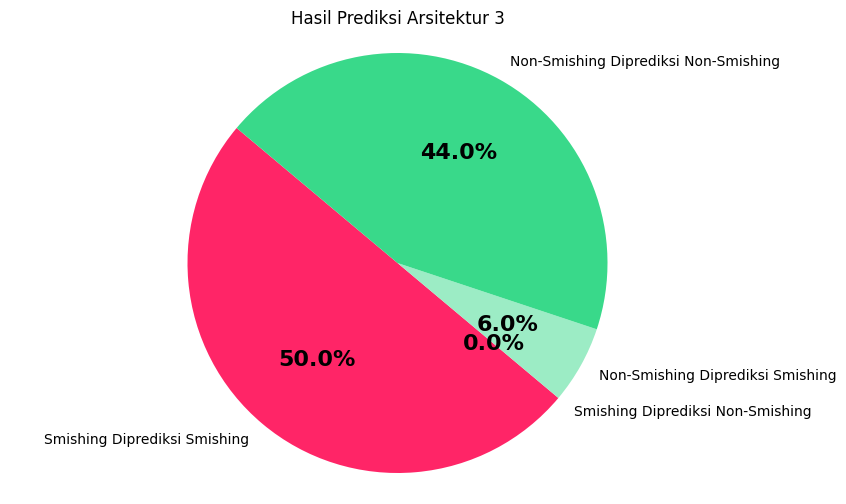

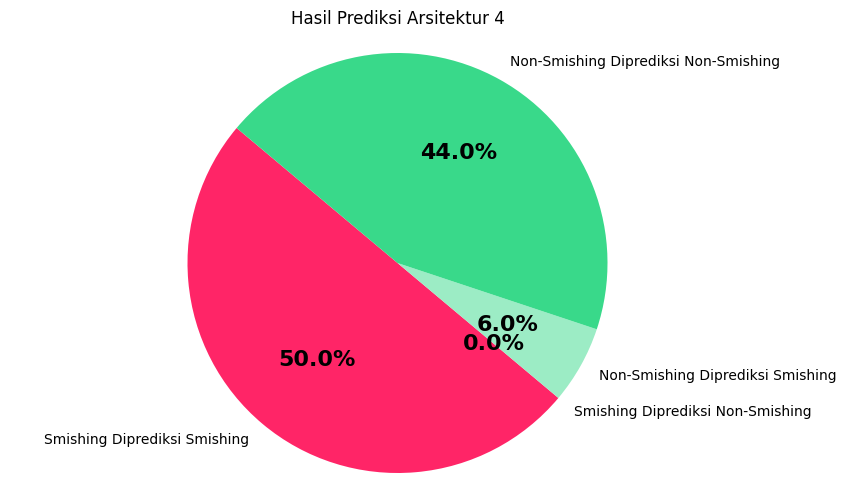

In [ ]:
for i in range(1, 5):
    plot_pie_chart(df_msg[f'Arsitektur {i}'], f'Arsitektur {i}')

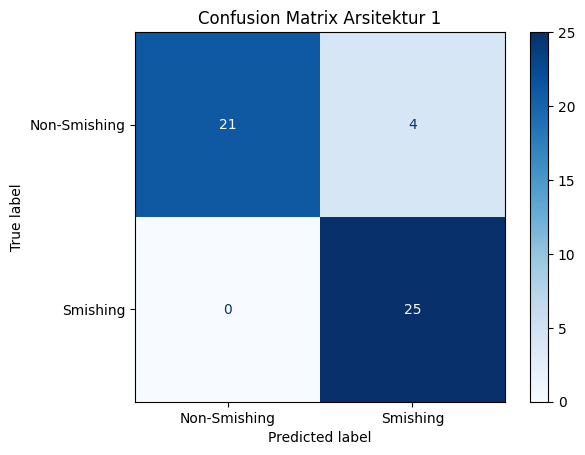

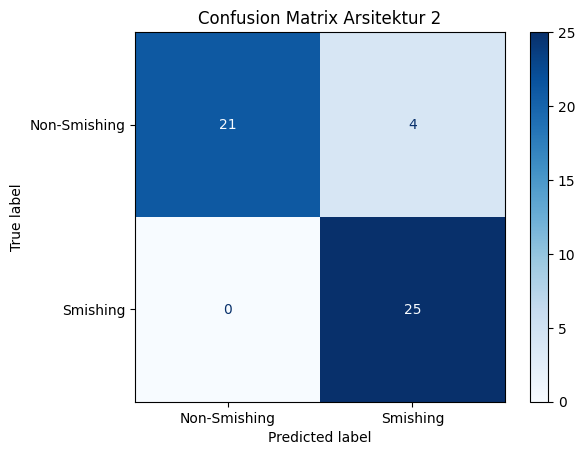

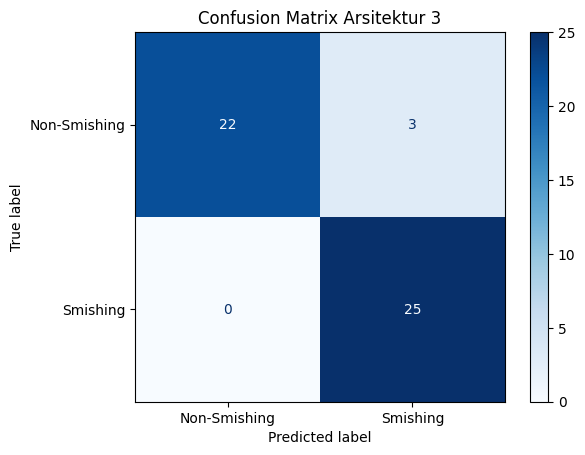

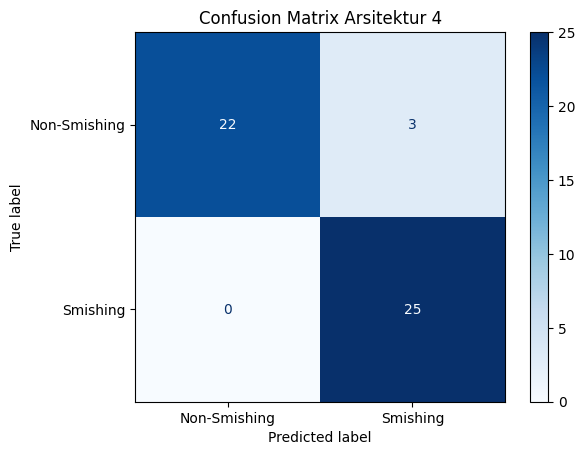

In [ ]:
for i in range(1, 5):
    plot_confusion_matrix(df_msg[f'Arsitektur {i}'], f'Arsitektur {i}')

In [ ]:
display(df_msg)

,Data,Kategori,Arsitektur 1,Arsitektur 2,Arsitektur 3,Arsitektur 4
0,"Salam, saya Wina dari HRD Tokopedia Indonesia....",phishing,1,1,1,1
1,"Halo, kami dari Tim Rekrutmen Shopee, ingin me...",phishing,1,1,1,1
2,Selamat! Anda terpilih untuk mendapatkan vouch...,phishing,1,1,1,1
3,"Hai, saya Fitri dari Customer Service Gojek. K...",phishing,1,1,1,1
4,"Halo, pinjaman sebesar Rp 10 juta Anda telah d...",phishing,1,1,1,1
5,Selamat! Anda telah terpilih sebagai pemenang ...,phishing,1,1,1,1
6,"Nasabah yang terhormat, rekening Anda telah te...",phishing,1,1,1,1
7,"Selamat, Anda telah terpilih sebagai pemenang ...",phishing,1,1,1,1
8,"Halo, saya Dimas dari HRD Bukalapak. Kami seda...",phishing,1,1,1,1
9,Selamat datang di program kerja paruh waktu La...,phishing,1,1,1,1


In [ ]:
# teks = [
#     "kNr-872940 adalah kode verifikasi lo. Demi keamanan, jangan bagiin kode ini.",
#     "Assalamu'alaikum, dikabarin bahwa besok Hari Rabu dan Kamis, 19 dan 20 Juli 2023 siswa kelas 4 Penanggungan libur karena tahun baru Hijriyah. Masuk lagi hari Jum'at, 21 Juli 2023. Thanks ya atas perhatiannya 🙏",
#     "Promo Spesial dari Bebek Kaleyo. Pencinta bebek harus GoFood-in! Menu Nasi + Bebek Muda 1/2 Ekor Goreng + Minuman cuma Rp. 42.000. Kelezatan bebek muda goreng sama sambalnya jadi perpaduan yang pas di lidah dan puas di perut. 🚨GoFood-in sekarang, promo terbatas s.d 12 Juni!",
#     "Semoga yang putri tahun depan bisa pertahanin gelar juara dan yang putra bisa nyusul yang putri buat dapet juara pak 🤲🤲",
#     "Assalamu'alaikum, permisi pak Lutfi. Buat pekan depan udah gak ada pekan efektif ya pak. Kalau pekan depan saya izin gak masuk sekolah buat nyicil tugas yang belum kelar di rumah boleh gak pak? 🙏",
#     "Assalamu'alaikum, permisi pak Lutfi. Atas nama pribadi saya ucapin Minal Aidzin Wal Faidzin mohon maaf lahir batin pak 🙏",
#     "Assalamu'alaikum, permisi pak Lutfi maaf ganggu waktunya pak. Izin tanya pak, bapak hari ini ada waktu luang jam berapa ya pak? Karena saya mau ketemu bapak buat persiapan take video besok pak? 🙏 Thanks pak sebelumnya 🙏",
#     "DISKON 55% dari GoFood 🚨. Yuk, order makanan favorit lo di GoFood lagi! Lo bisa dapetin DISKON s.d. 55% 😍 Kapan lagi?! Nih, ikutin caranya di bawah: 1. Klik 'Order di GoFood' pada pesan ini 2. Pilih resto & menu favorit lo 3. Klik Pasang Promo di halaman order dan pilih promonya 4. Makanan lo siap diantar. Jangan sampe kelewatan, cek promonya sekarang~"
# ]


In [ ]:
# msg_clean = [preprocess_global(tek) for tek in teks]

# msg_char_level = preprocess_char_level(msg_clean)
# print(msg_char_level)
# msg_word_level = preprocess_word_level(msg_clean)
# print(msg_word_level)

[[11  5  9 ...  0  0  0]
 [ 3  8  8 ...  0  0  0]
 [15  9 16 ...  0  0  0]
 ...
 [ 3  8  8 ...  0  0  0]
 [ 3  8  8 ...  0  0  0]
 [19  4  8 ...  0  0  0]]
[[   1   34  493 ...    0    0    0]
 [ 215    1  387 ...    0    0    0]
 [ 120  217    1 ...    0    0    0]
 ...
 [ 215  402  499 ...    0    0    0]
 [ 215  402  499 ...    0    0    0]
 [ 453    1 2335 ...    0    0    0]]


In [ ]:
# inputs = [msg_char_level, msg_word_level]

In [ ]:


# predictions_probs = best_model_train[1].predict(inputs)
# new_predictions = (predictions_probs > 0.5).astype(int)
# print(new_predictions)

1/1 [==============================] - 0s 237ms/step
[[0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]]


In [ ]:
# # Data from the new image with calculated standard deviations
# std_dev_data = {
#     "Foreground": [0.514, 0.568, None, None, 0.194, 0.24, 0.544, 0.36, 0.714, 0.61],
#     "Background": [0.54, 0.69, None, None, 0.214, 0.29, 0.516, 0.41, 0.688, 0.54],
#     "Layar Kunci": [0.544, 0.708, None, None, 0.224, 0.18, 0.513, 0.55, 0.668, 0.5]
# }

# std_dev_df = pd.DataFrame(std_dev_data)

# # Calculate mean and standard deviation for the new standard deviations
# std_dev_mean_values = std_dev_df.mean(numeric_only=True)
# std_dev_std_dev_values = std_dev_df.std(numeric_only=True)

# std_dev_mean_values, std_dev_std_dev_values


(Foreground     0.468000
 Background     0.486000
 Layar Kunci    0.485875
 dtype: float64,
 Foreground     0.184118
 Background     0.172100
 Layar Kunci    0.190140
 dtype: float64)